**Homework 1**

**Keito Watanabe (s6kewata),
Haveesh Singirikonda (s6gusing)**



1.) The parameter $J$ embodies the spin interaction forces between the nearest neighbours in the arrangement of spins. Usually, we write $J_{ij}$ as the interaction term between the adjacent spins $s_i$ and $s_j$. In this problem, we use the simplification that the interaction between all the spins is the same, which is $J$

2.) Periodic boundary conditions here refers to the fact that the first and last elements in the arrangement are adjacent to each other. So in this case,  we also add the term, $-J s_1 s_{N}$ to the hamiltonian. This is a periodic boundary condition as we are able to connect the first element with the last element, hence forming a loop of sorts. 

What we have to do:

1. Define Hamiltonian function (use one given  on assignment)
2. Define probability function (same as above)
3. Define partition function (same as above)
4. Define magnetization per spin: $m = M/N_l = \sum_i s_i / N_l$
5. Define function that initialize random number of spin configurations
- for a number of lattice sites $N_l$ and number of configuations $N_{MC}$
- initialize them using Metropolis-Hastings => use the prob. distribution for this.
  - alternatively use uniformly if we are running out of time.

6. Define function that evaluates the expectation of observable:
$<O> = \sum_{\vec{s}} O(\vec{s}) P(\vec{s}) / Z$



Before presenting, the results, the dimensionless quantities in this analysis would be the quantities $J/T$ and $h/T$. This is because, in the Probability function, for example,  $P = exp(-H(s)/k_B T)$. The terms inside the exponential should not have dimensions, and we have also set $k_B =1$. So $H(s)/T$ should be dimensionless, which implies $J/T$ and $h/T$ are dimensionless.

In [ ]:
import numpy as np

In [ ]:
def H_d(s, J, h):
  '''Hamiltonian as function of a particular spin configuration s
     for a single dimension d '''
  N = len(s)  # number of lattice sites
  # interaction term, include last term due to periodic BC
  coupling_term = J * (np.sum(np.array([s[i]*s[i+1] for i in range(N-1)]))  
                        + s[0]*s[N-1])
  bfield_term = h * np.sum(s)
  return - coupling_term - bfield_term

def P_factor(s, J, h, T):
  '''Boltmann distribution factor'''
  return np.exp(-H_d(s, J, h) / T)

def partition(s_arr, J, h, T):
  '''Partition function'''
  return np.sum([P_factor(s, J, h, T) for s in s_arr])

def deltaS(s, s_flipped, J, h, T):
  '''Change in energy == change in action'''
  return ( H_d(s_flipped, J, h) - H_d(s, J, h) ) / T

def m(s):
  '''Magnetization per spin as function of spin configuration'''
  return np.mean(s)

In [ ]:
def init_spins(Nl, J, h, T, N_config, Ntherm=100):
  '''Initialize spins based on Metropolis-Hastings algorithm'''

  # set initial configuration to be [1, -1, 1, ...]
  s_0 = np.array([(-1)**i for i in range(Nl)])

  # thermalize (get a random initial configuration)
  for j in range(Ntherm):
    flip_idx = np.random.randint(0,Nl,size=Nl)
    s_flipped = np.copy(s_0)  # shallow copy s
    s_flipped[flip_idx] *= -1

    # evaluate change in action
    dS = deltaS(s_0, s_flipped, J, h, T)

    # perform metropolis-hastings step
    if dS < 0:  # if energy is lowered
      s_0 = s_flipped
    else:
      y = np.random.uniform(0, 1)
      if y <= np.exp(-dS):  
        s_0 = s_flipped
      else:
        pass  # return original

  s_arr = np.zeros((N_config, Nl))

  # generate spin configurations randomly
  for i in range(N_config):

    # generate random spin configuration
    s = np.random.randint(0,high=2,size=Nl)
    s[s==0] = -1

    # set random site to be flipped
    flip_idx = np.random.randint(0,Nl,size=Nl)
    s_flipped = s  
    s_flipped[flip_idx] *= -1

    # print(s_flipped, s)

    # evaluate change in action
    dS = deltaS(s, s_flipped, J, h, T)

    # perform metropolis-hastings step
    if dS < 0:  # if energy is lowered
      s_arr[i, :] = s_flipped
    else:
      y = np.random.uniform(0, 1)
      if y <= np.exp(-dS):  
        s_arr[i, :] = s_flipped
      else:
        s_arr[i, :] = s  # return original

  return s_arr


In [ ]:
# set initial parameters
J = 1
T = 1  # set low since we perform with lattice spins
Nl = 10   # number of lattice sites
N_config = 5000   # number of spin configurations

h_arr = np.linspace(-1, 1, 50)
# h_arr = [1]
m_exp_arr = np.zeros(len(h_arr))

for i, h in enumerate(h_arr):
  # array of spin configurations (N_config, Nl)
  s_arr = init_spins(Nl, J, h, T, N_config)

  # get partition function
  Z = partition(s_arr, J, h, T)

  # get magnetization per spin 
  m_exp = np.sum([m(s) * P_factor(s, J, h, T) for s in s_arr]) / Z

  # print(m_exp)
  m_exp_arr[i] = m_exp


Using these functions, we can now determine the numerical value of $m$. For comparison, we use the theoretical functions expression, at both finite N and the thermodynamic limit. We directly use the functions from lecture03.pdf.

In [ ]:
def mExactN(J,h,N):
    s = np.sinh(h)
    c = np.cosh(h)
    expm4J = np.exp(-4*J)
    ratio = (c-np.sqrt(s**2+expm4J))/(c+np.sqrt(s**2+expm4J))
    answer = (1-ratio**N)/(1+ratio**N)
    answer *= s/np.sqrt(s**2+expm4J)
    return answer

def mExact(J,h):
    s = np.sinh(h)
    c = np.cosh(h)
    expm4J = np.exp(-4*J)
    answer = s/np.sqrt(s**2+expm4J)
    return answer

Now, we can plot these results. We have plotted the simulated results, along with the theoretical estimates, at both the finite limit and the Thermodynamic limit.

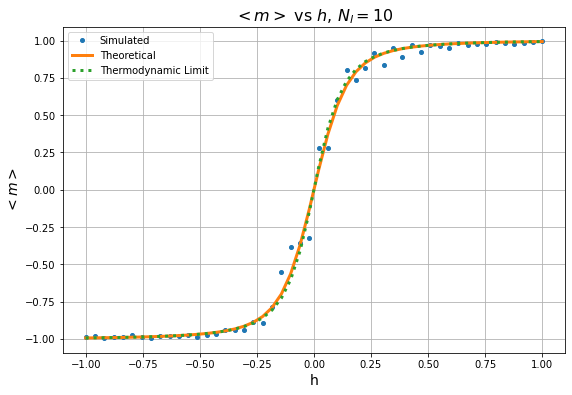

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9,6))

ax.plot(h_arr, m_exp_arr, ls="", marker="o", ms=4.0,label='Simulated')
ax.plot(h_arr, mExactN(J, h_arr, Nl),label='Theoretical', lw=3.0)
ax.plot(h_arr,mExact(J,h_arr),label='Thermodynamic Limit',ls=':', lw=3.0)
ax.legend()
ax.set_xlabel('h', fontsize=14)
ax.set_ylabel('$<m>$', fontsize=14)
ax.set_title("$<m>$ vs $h$, $N_l = {0}$".format(Nl), fontsize=16)
ax.grid();

In [ ]:
# set initial parameters
J = 1
T = 1  # set low since we perform with lattice spins
h = 1   # external magnetic field
N_config = 5000   # number of spin configurations

Nl_arr = np.arange(1, 10, step=1, dtype=int)
m_exp_arr = np.zeros(len(Nl_arr))

for i, Nl_i in enumerate(Nl_arr):
  # array of spin configurations (N_config, Nl_i)
  s_arr = init_spins(Nl_i, J, h, T, N_config)

  # get partition function
  Z = partition(s_arr, J, h, T)

  # get magnetization per spin .
  m_exp = np.sum([m(s) * P_factor(s, J, h, T) for s in s_arr]) / Z

  # print(m_exp)
  m_exp_arr[i] = m_exp

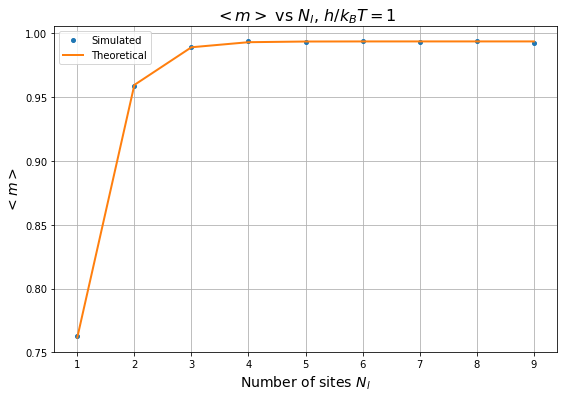

In [ ]:
import matplotlib.pyplot as plt

m_theo_N = [mExactN(J,h,N_in) for N_in in Nl_arr]

fig, ax = plt.subplots(figsize=(9,6))

ax.plot(Nl_arr, m_exp_arr, ls="", marker="o", ms=4.0,label='Simulated')
ax.plot(Nl_arr,m_theo_N,label='Theoretical', lw=2.0)
ax.legend()
ax.set_xlabel('Number of sites $N_l$', fontsize=14)
ax.set_ylabel('$<m>$', fontsize=14)
ax.set_title("$<m>$ vs $N_l$, $h / k_B T = {0}$".format(h), fontsize=16)
ax.grid();

In the plots comparing $<m>$ vs $N_l$, we observe that for small number of lattice sites, the magnetization per spin $<m>$ is significantly lower than those with higher number of lattice sites. This also shows the convergence of the magnetization per spin so that as we have higher number of lattice sites the true value of $<m> \sim 1$ is attained, as expected.